In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cmdstanpy
import numpy as np
import cmdstanpy
#cmdstanpy.install_cmdstan(compiler=True)
import os
import json

In [5]:
op_sample = pd.read_csv("data/instacart/order_product_sample.csv")
o_sample = pd.read_csv("data/instacart/orders_sample.csv")
p_sample = pd.read_csv("data/instacart/products_sample.csv")
op_sample = op_sample.merge(p_sample[["product_id", "aisle_id"]])
with open('data/instacart/test_orders.json') as json_file:
    test_orders = json.load(json_file)
with open('stan_models/IC_GP_data.json') as json_file:
    gp_data = json.load(json_file)
with open('stan_models/instacart_data.json') as json_file:
    logit_data = json.load(json_file)

with open('data/instacart/products.json') as json_file:
    products = json.load(json_file)

with open('data/instacart/orders_attr.json') as json_file:
    orders_attr = json.load(json_file)

with open('data/instacart/orders_nodes.json') as json_file:
    orders_nodes = json.load(json_file)

FileNotFoundError: [Errno 2] No such file or directory: 'data/instacart/test_orders.json'

In [4]:
test_order = test_orders[0]
X_new = [list(orders_attr[str(test_order)].values())[1:]]
N_new = len(X_new)

gp_data["X_new"] = X_new
gp_data["N_new"] = N_new

with open('stan_models/IC_GP_data_new.json', 'w', encoding='utf-8') as f:
    json.dump(gp_data, f)

In [5]:
gp = cmdstanpy.from_csv("stan_models/fitted_gp")
gp_ppc_model = cmdstanpy.CmdStanModel(stan_file='stan_models/gamma-poisson_ppc.stan', #force_compile=True
                                             )
gp_new_quantities = gp_ppc_model.generate_quantities(data="stan_models/IC_GP_data_new.json", previous_fit=gp#, show_console=True
                                                         )

11:32:48 - cmdstanpy - INFO - Chain [1] start processing
11:32:48 - cmdstanpy - INFO - Chain [2] start processing
11:32:48 - cmdstanpy - INFO - Chain [3] start processing
11:32:48 - cmdstanpy - INFO - Chain [4] start processing
11:32:49 - cmdstanpy - INFO - Chain [1] done processing
11:32:49 - cmdstanpy - INFO - Chain [2] done processing
11:32:49 - cmdstanpy - INFO - Chain [4] done processing
11:32:49 - cmdstanpy - INFO - Chain [3] done processing


Moda posterior: 7
Intervalo 25%-75%: [ 1. 16.]
Cantidad real de objetos: 21


<Axes: ylabel='Count'>

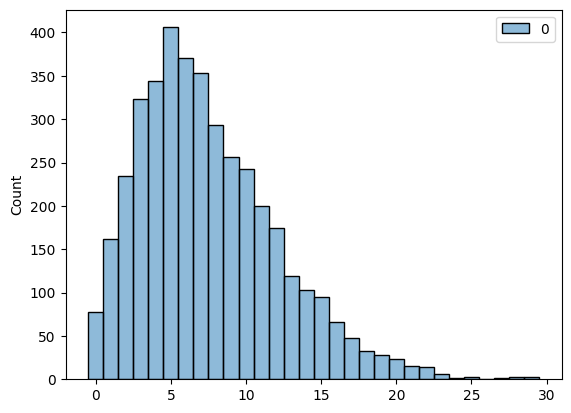

In [6]:
from scipy.stats import gaussian_kde

lambdas = gp_new_quantities.lambda_new


kde = gaussian_kde(lambdas.T)
x_vals = np.linspace(0, int(lambdas.max()), int(lambdas.max())+1)
x_vals
y_vals = kde(x_vals)
print("Moda posterior: " + str(np.argmax(y_vals)))
print("Intervalo 25%-75%: " + str(np.percentile(gp_new_quantities.y_new.T, q=(5,95))))
print("Cantidad real de objetos: " + str(len(op_sample[op_sample.order_id == test_orders[0]].aisle_id.unique())))
sns.histplot(gp_new_quantities.y_new, discrete=True)

In [ ]:
test_order1 = o_sample[o_sample["order_id"]==test_order]
test_user = test_order1.user_id.values[0]
test_attr = test_order1[["lunes", "martes", "miercoles", "jueves", "viernes", "sabado", "pm"]].values

w_new = logit_data["I"] * list(test_attr.tolist())
u_new = []
i_new = []
j_new = logit_data["I"] * [int(test_user)]
for s in products.keys():
    u_new.append(list(products[s].values()))
    i_new.append(int(s))

logit_data["w_new"] = w_new
logit_data["u_new"] = u_new
logit_data["i_new"] = i_new
logit_data["j_new"] = j_new
logit_data["N_new"] = logit_data["I"]

with open('stan_models/instacart_data_new.json', 'w', encoding='utf-8') as f:
    json.dump(logit_data, f)

In [8]:
fit_logit = cmdstanpy.from_csv("stan_models/fitted_logit")

bernoulli_ppc_model = cmdstanpy.CmdStanModel(stan_file='stan_models/logit_ppc.stan', #force_compile=True
                                             )
new_quantities = bernoulli_ppc_model.generate_quantities(data="stan_models/instacart_data_new.json", previous_fit=fit_logit,# show_console=True
                                                         )

11:32:50 - cmdstanpy - INFO - Chain [1] start processing
11:32:50 - cmdstanpy - INFO - Chain [2] start processing
11:32:50 - cmdstanpy - INFO - Chain [3] start processing
11:32:50 - cmdstanpy - INFO - Chain [4] start processing
11:32:51 - cmdstanpy - INFO - Chain [1] done processing
11:32:51 - cmdstanpy - INFO - Chain [3] done processing
11:32:51 - cmdstanpy - INFO - Chain [4] done processing
11:32:51 - cmdstanpy - INFO - Chain [2] done processing


In [9]:
import networkx as nx
edges = []
for d in orders_nodes.keys():
    nodes = orders_nodes[d]
    for node1 in nodes:
        for node2 in nodes:
            if node1 != node2:
                edges.append((node1, node2))
G = nx.from_edgelist(edges)

layout = nx.spring_layout(k=5, iterations=2000, G=G)
#nx.draw(G, layout)

from scipy.stats import gaussian_kde
from tqdm import tqdm
p_sujeto = {}
r_sujeto = {}
u_sujeto = {}
ps = []
rs = []
us = []
for s in tqdm(products.keys()):
    s = int(s)
    kde = gaussian_kde(new_quantities.theta_sim.T[s-1])
    x_vals = np.linspace(0, 1, 1000)
    y_vals = kde(x_vals)
    p_sujeto[s] = {"p":x_vals[np.argmax(y_vals)]}
    r_sujeto[s] = {"r":np.diff(np.percentile(new_quantities.theta_sim.T[s-1], q=(5,95)))[0]}
    u_sujeto[s] = {"u":np.diff(np.percentile(new_quantities.u_sim.T[s-1], q=(5,95)))[0]}
    ps.append(new_quantities.y_sim.T[s-1].mean())
    rs.append(np.diff(np.percentile(new_quantities.theta_sim.T[s-1], q=(5,95)))[0])
    us.append(np.diff(np.percentile(new_quantities.u_sim.T[s-1], q=(5,95)))[0])

nx.set_node_attributes(G, p_sujeto)
nx.set_node_attributes(G, r_sujeto)
nx.set_node_attributes(G, u_sujeto)

100%|██████████| 90/90 [00:05<00:00, 16.39it/s]


Probabilidad míninma: 0.001001001001001001 & Probabilidad máxima: 0.5285285285285285
Rango de probabilidad míninmo: 0.01678740340499998 & Rango de probabilidad máximo: 0.2686855999999999


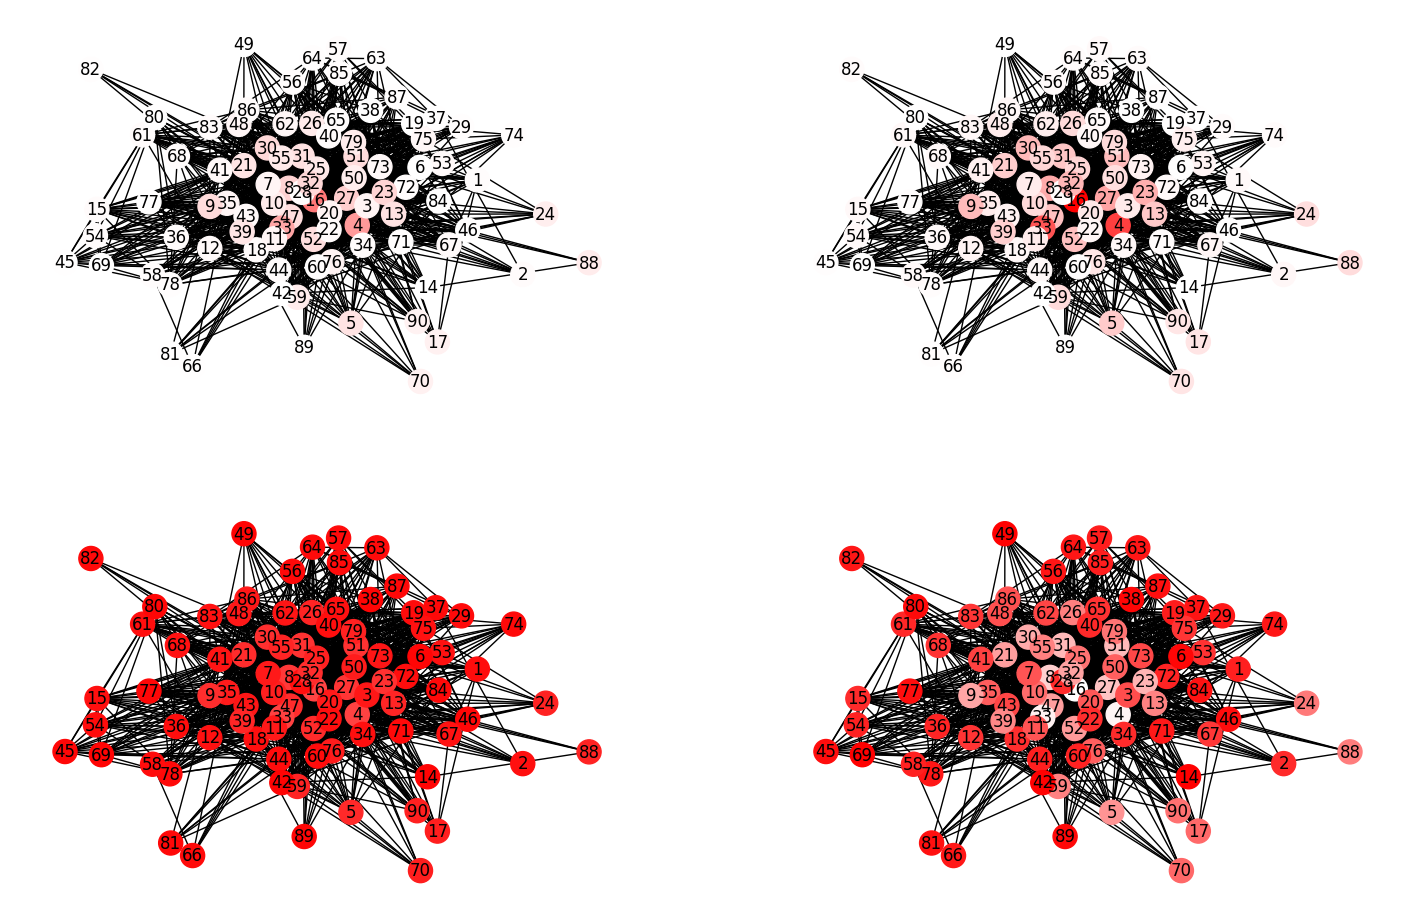

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable

# Crear colormap blanco → rojo
white_red = LinearSegmentedColormap.from_list("white_red", ["white", "red"])
red_white = LinearSegmentedColormap.from_list("red_white", ["red", "white"])
p_values = [G.nodes[n]["p"] for n in G.nodes]
r_values = [G.nodes[n]["r"] for n in G.nodes]
u_values = [G.nodes[n]["u"] for n in G.nodes]
pos = nx.spring_layout(G, k=2, iterations=100, seed=42)
plt.figure(figsize=(18,18))
plt.subplot(321)
nx.draw(
    G,
    node_color=p_values,
    cmap=white_red,     # azul-blanco-rojo
    vmin=0, vmax=1,      # escala entre 0 y 1
    with_labels=True,
    pos=pos
)
plt.subplot(322)
nx.draw(
    G,
    node_color=p_values,
    cmap=white_red,     # azul-blanco-rojo
    vmin=min(p_values), vmax=max(p_values),      # escala entre 0 y 1
    with_labels=True,
    pos=pos
)

plt.subplot(323)
nx.draw(
    G,
    node_color=r_values,
    cmap=red_white,     # azul-blanco-rojo
    vmin=0, vmax=1,      # escala entre 0 y 1
    with_labels=True,
    pos=pos
)

plt.subplot(324)
nx.draw(
    G,
    node_color=r_values,
    cmap=red_white,     # azul-blanco-rojo
    vmin=min(r_values), vmax=max(r_values),      # escala entre 0 y 1
    with_labels=True,
    pos=pos
)

print("Probabilidad míninma: " + str(min(p_values)) + " & Probabilidad máxima: " + str(max(p_values)))
print("Rango de probabilidad míninmo: " + str(min(r_values)) + " & Rango de probabilidad máximo: " + str(max(r_values)))
plt.show()

In [11]:
sorted_keys = sorted(p_sujeto, key=lambda k: p_sujeto[k]['p'], reverse=True)
top_n = 6
top_keys = sorted_keys[:top_n]

In [15]:
true = op_sample[op_sample.order_id == test_order].aisle_id.unique().tolist()
TP = set(true) & set(top_keys)
FN = set(true) - set(set(true) & set(top_keys))
FP = set(top_keys) - set(true)

In [ ]:
FP

{8, 23, 27}